# Modèles de covariance et processus gaussien : Solution des exercices


In [1]:
import openturns as ot
import pylab as pl
import openturns.viewer as otv
from matplotlib import pyplot as plt
import math

In [2]:
# Amplitude values
amplitude = [3.5]
# Scale values
scale = [1.5]
# Covariance model
myModel = ot.SquaredExponential(scale, amplitude)

## Les processus gaussiens dans OpenTURNS

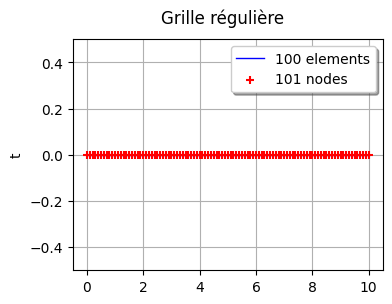

In [3]:
xmin = 0.0
step = 0.1
n = 100
myTimeGrid = ot.RegularGrid(xmin, step, n + 1)
graph = myTimeGrid.draw()
graph.setTitle("Grille régulière")
_ = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

Puis on crée le processus. Par défaut, la tendance est nulle.

In [4]:
process = ot.GaussianProcess(myModel, myTimeGrid)
print(process)

GaussianProcess(trend=[x0]->[0], covariance=SquaredExponential(scale=[1.5], amplitude=[3.5]))


On génère ensuite un ensemble de 10 trajectoires avec la méthode `getSample`. Ces trajectoires sont stockées dans un `ProcessSample`. 

In [5]:
nbTrajectories = 10
sample = process.getSample(nbTrajectories)
type(sample)

openturns.func.ProcessSample

Il est facile de dessiner ces trajectoires avec la méthode `drawMarginal`.

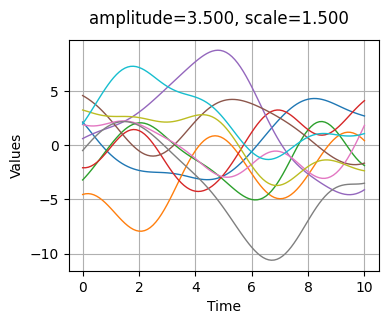

In [6]:
graph = sample.drawMarginal(0)
graph.setTitle("amplitude=%.3f, scale=%.3f" % (amplitude[0], scale[0]))
_ = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

Pour faciliter le travail, on créée une fonction qui dessiner le nombre donné de trajectoires.

In [7]:
def plotCovarianceModel(myCovarianceModel, myTimeGrid, nbTrajectories):
    """Plots the given number of trajectories with given covariance model."""
    process = ot.GaussianProcess(myCovarianceModel, myTimeGrid)
    sample = process.getSample(nbTrajectories)
    graph = sample.drawMarginal(0)
    graph.setTitle("")
    return graph

Le paramètre d'amplitude caractérise la variance du processus. Une valeur plus grande implique des valeurs absolues plus élevées. 

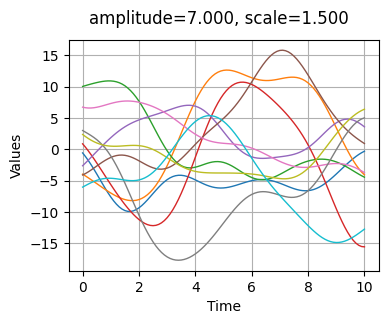

In [8]:
amplitude = [7.0]
scale = [1.5]
myModel = ot.SquaredExponential(scale, amplitude)
graph = plotCovarianceModel(myModel, myTimeGrid, 10)
graph.setTitle("amplitude=%.3f, scale=%.3f" % (amplitude[0], scale[0]))
_ = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})


Jouer sur l'unique paramètre d'échelle revient ici à dilater ou contracter le processus suivant le « temps » $x$. 

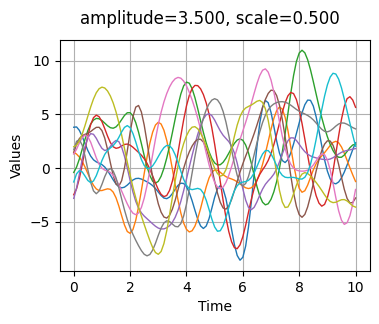

In [9]:
amplitude = [3.5]
scale = [0.5]
myModel = ot.SquaredExponential(scale, amplitude)
graph = plotCovarianceModel(myModel, myTimeGrid, 10)
graph.setTitle("amplitude=%.3f, scale=%.3f" % (amplitude[0], scale[0]))
_ = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

## Définir la tendance


In [10]:
f = ot.SymbolicFunction(["x"], ["2*x"])
fTrend = ot.TrendTransform(f, myTimeGrid)

In [11]:
amplitude = [3.5]
scale = [1.5]
myModel = ot.SquaredExponential(scale, amplitude)
process = ot.GaussianProcess(fTrend, myModel, myTimeGrid)
print(process)

GaussianProcess(trend=[x]->[2*x], covariance=SquaredExponential(scale=[1.5], amplitude=[3.5]))


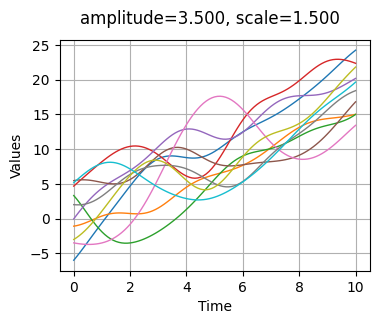

In [12]:
nbTrajectories = 10
sample = process.getSample(nbTrajectories)
graph = sample.drawMarginal(0)
graph.setTitle("amplitude=%.3f, scale=%.3f" % (amplitude[0], scale[0]))
_ = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

## Exercices

### Solution de l'exercice 1 : noyau de Matérn et noyau exponentiel

In [13]:
def createGridFromGraphList(listOfGraphs, numberOfRows=2, numberOfColumns=None):
    """
    Create a GridLayout with given number of rows and columns

    Parameters
    ----------
    listOfGraphs : list(ot.Graph)
        The graphs.
        The number of graphs must be lower or equal than the number of
        grid cells, i.e. numberOfRows x numberOfColumns.
    numberOfRows : int
        The number of rows in the grid.
    numberOfColumns : int
        The number of columns in the grid.

    Returns
    -------
    grid : ot.GridLayout(numberOfRows, numberOfColumns)
        The grid of graphs.
    """
    numberOfGraphs = len(listOfGraphs)
    if numberOfColumns is None:
        numberOfColumns = math.ceil(numberOfGraphs / numberOfRows)
    if numberOfGraphs > numberOfRows * numberOfColumns:
        raise ValueError(
            f"Number of graphs is {numberOfGraphs} "
            f"but nb. rows = {numberOfRows} and nb. columns = {numberOfColumns}"
        )
    grid = ot.GridLayout(numberOfRows, numberOfColumns)
    index = 0
    for i in range(numberOfRows):
        for j in range(numberOfColumns):
            if index >= numberOfGraphs:
                break
            grid.setGraph(i, j, listOfGraphs[index])
            index += 1
    return grid

In [14]:
amplitude = [1.0]
scale = [1.0]
listOfCovarianceModels = []
listOfCovarianceModels.append(ot.MaternModel(scale, amplitude, 2.5))
listOfCovarianceModels.append(ot.MaternModel(scale, amplitude, 1.5))
listOfCovarianceModels.append(ot.MaternModel(scale, amplitude, 0.5))
listOfCovarianceModels.append(ot.ExponentialModel(scale, amplitude))

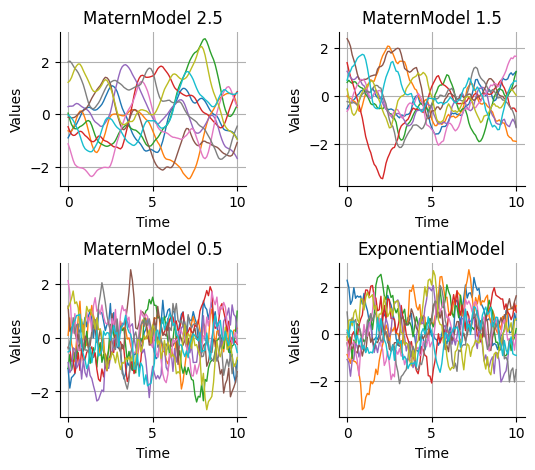

In [15]:
nbTrajectories = 10
listOfGraphs = []
for covarianceModel in listOfCovarianceModels:
    graph = plotCovarianceModel(covarianceModel, myTimeGrid, nbTrajectories)
    covarianceModelName = covarianceModel.getClassName()
    if covarianceModelName == "MaternModel":
        graph.setTitle(f"{covarianceModelName} {covarianceModel.getNu():.1f}")
    else:
        graph.setTitle(f"{covarianceModelName}")
    listOfGraphs.append(graph)

grid = createGridFromGraphList(listOfGraphs, numberOfRows=2)
_ = otv.View(grid, figure_kw={"figsize": (6.0, 5.0)})
plt.subplots_adjust(wspace=0.5, hspace=0.5)

On observe que, lorsque $\nu$ augmente, les trajectoires sont plus régulières. 
On observe que le modèle exponentiel produit des trajectoires très irrégulières.

### Solution de l'exercice 2 : matrice de covariance

In [16]:
amplitude = [3.5]
scale = [1.5]
myModel = ot.SquaredExponential(scale, amplitude)

In [17]:
covarianceMatrix = myModel.discretize(myTimeGrid)
covarianceMatrix.getDimension()

101

On observe que la matrice est de taille 101-par-101.

In [18]:
type(covarianceMatrix)

openturns.typ.CovarianceMatrix

In [19]:
covarianceMatrix[0:5, 0:5]

class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=5 columns=5 values=[12.25,12.2228,12.1416,12.0074,11.8221,12.2228,12.25,12.2228,12.1416,12.0074,12.1416,12.2228,12.25,12.2228,12.1416,12.0074,12.1416,12.2228,12.25,12.2228,11.8221,12.0074,12.1416,12.2228,12.25]

On observe que la matrice `covarianceMatrix` est une `CovarianceMatrix`. 

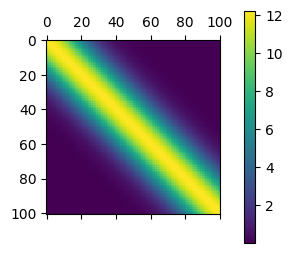

In [20]:
ax = plt.matshow(covarianceMatrix)
plt.colorbar(ax, pad=0.1)
fig = ax.get_figure()
fig.set_figwidth(3.0)
fig.set_figheight(3.0)


On observe que deux points distants d'un indice supérieur ou égal à 40 ont une covariance inférieure à 6.

### Solution de l'exercice 3 : générer des réalisations d'un vecteur gaussien

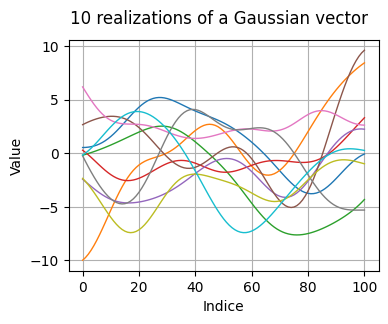

In [21]:
n = 100
mu = [0.0] * (n + 1)
myNormalVector = ot.Normal(mu, covarianceMatrix)
nbTrajectories = 10
trajectoires = myNormalVector.getSample(nbTrajectories)
palette = ot.Drawable.BuildDefaultPalette(nbTrajectories)
graph = ot.Graph(
    f"{nbTrajectories} realizations of a Gaussian vector", "Indice", "Value", True
)
x = range(n + 1)
for i in range(nbTrajectories):
    curve = ot.Curve(x, trajectoires[i, :])
    graph.add(curve)
graph.setColors(palette)  # Add colors
_ = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})
plt.subplots_adjust(wspace=0.5, hspace=0.5)

On observe que l'on a des trajectoires similaires aux trajectoires observées dans le cas d'un processus gaussien. 

* Les trajectoires sont très régulières. 
* L'amplitude de variation est bien identique à l'amplitude du processus gaussien.

C'est le résultat attendu, puisque chaque réalisation d'un processus gaussien *est* un vecteur gaussien. 

### Solution de l'exercice 4 : processus gaussien et vecteur gaussien

In [22]:
# Modèle de covariance
amplitude = [3.5]
scale = [1.5]
myModel = ot.SquaredExponential(scale, amplitude)
# Grille temporelle
xmin = 0.0
step = 0.1
n = 100
myTimeGrid = ot.RegularGrid(xmin, step, n + 1)
# Processus Gaussien
process = ot.GaussianProcess(myModel, myTimeGrid)
process

class=GaussianProcess mesh=class=Mesh name=Unnamed dimension=1 vertices=class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=101 dimension=1 description=[t] data=[[0],[0.1],[0.2],[0.3],[0.4],[0.5],[0.6],[0.7],[0.8],[0.9],[1],[1.1],[1.2],[1.3],[1.4],[1.5],[1.6],[1.7],[1.8],[1.9],[2],[2.1],[2.2],[2.3],[2.4],[2.5],[2.6],[2.7],[2.8],[2.9],[3],[3.1],[3.2],[3.3],[3.4],[3.5],[3.6],[3.7],[3.8],[3.9],[4],[4.1],[4.2],[4.3],[4.4],[4.5],[4.6],[4.7],[4.8],[4.9],[5],[5.1],[5.2],[5.3],[5.4],[5.5],[5.6],[5.7],[5.8],[5.9],[6],[6.1],[6.2],[6.3],[6.4],[6.5],[6.6],[6.7],[6.8],[6.9],[7],[7.1],[7.2],[7.3],[7.4],[7.5],[7.6],[7.7],[7.8],[7.9],[8],[8.1],[8.2],[8.3],[8.4],[8.5],[8.6],[8.7],[8.8],[8.9],[9],[9.1],[9.2],[9.3],[9.4],[9.5],[9.6],[9.7],[9.8],[9.9],[10]] simplices=[[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9],[9,10],[10,11],[11,12],[12,13],[13,14],[14,15],[15,16],[16,17],[17,18],[18,19],[19,20],[20,21],[21,22],[22,23],[23,24],[24,25],[25,26],[26,27],[27,28],[28,29],[29,30],[30,31],[31,32],[32,33],[33,34],[34,35],[35,36],[36,37],[37,38],[38,39],[39,40],[40,41],[41,42],[42,43],[43,44],[44,45],[45,46],[46,47],[47,48],[48,49],[49,50],[50,51],[51,52],[52,53],[53,54],[54,55],[55,56],[56,57],[57,58],[58,59],[59,60],[60,61],[61,62],[62,63],[63,64],[64,65],[65,66],[66,67],[67,68],[68,69],[69,70],[70,71],[71,72],[72,73],[73,74],[74,75],[75,76],[76,77],[77,78],[78,79],[79,80],[80,81],[81,82],[82,83],[83,84],[84,85],[85,86],[86,87],[87,88],[88,89],[89,90],[90,91],[91,92],[92,93],[93,94],[94,95],[95,96],[96,97],[97,98],[98,99],[99,100]] trend=class=TrendTransform inherited from class=VertexValueFunction evaluation=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x0,y0] evaluationImplementation=class=TrendEvaluation name=Unnamed function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,y0] evaluationImplementation=class=ConstantEvaluation name=Unnamed constant=class=Point name=Unnamed dimension=1 values=[0] gradientImplementation=class=ConstantGradient name=Unnamed constant=class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[0] hessianImplementation=class=NullHessian name=Unnamed inputDimension=1 outputDimension=1 gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=2 values=[1e-05,1e-05] evaluation=class=TrendEvaluation name=Unnamed function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,y0] evaluationImplementation=class=ConstantEvaluation name=Unnamed constant=class=Point name=Unnamed dimension=1 values=[0] gradientImplementation=class=ConstantGradient name=Unnamed constant=class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[0] hessianImplementation=class=NullHessian name=Unnamed inputDimension=1 outputDimension=1 hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=2 values=[0.0001,0.0001] evaluation=class=TrendEvaluation name=Unnamed function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,y0] evaluationImplementation=class=ConstantEvaluation name=Unnamed constant=class=Point name=Unnamed dimension=1 values=[0] gradientImplementation=class=ConstantGradient name=Unnamed constant=class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[0] hessianImplementation=class=NullHessian name=Unnamed inputDimension=1 outputDimension=1 covarianceModel=class=SquaredExponential scale=class=Point name=Unnamed dimension=1 values=[1.5] amplitude=class=Point name=Unnamed dimension=1 values=[3.5] covarianceCholeskyFactor=class=TriangularMatrix dimension=0 implementation=class=MatrixImplementation name=Unnamed rows=0 columns=0 values=[] isInitialized=false hasStationaryTrend=true ch

Nous allons stocker les valeurs de l'échantillons pour la maille i=30. Cela correspond à la date $x_i$.

In [23]:
i = 30
timeGridValues = myTimeGrid.getValues()
xi = timeGridValues[i]
xi

3.0

Pour visualiser la position de cette date dans la grille temporelle, nous générons 10 trajectoires puis nous traçons un trait vertical à la date $x_i=3$.

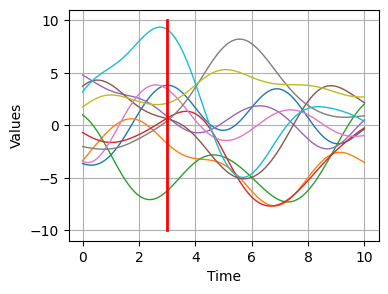

In [24]:
nbTrajectories = 10
sample = process.getSample(nbTrajectories)

graph = sample.drawMarginal(0)
curve = ot.Curve([xi, xi], [-10, 10])
curve.setColor("red")
curve.setLineWidth(2)
graph.add(curve)
graph.setTitle("")
_ = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

Chaque trajectoire coupe la ligne verticale rouge à une valeur différente, certaines plus basses et d'autres plus hautes. Nous souhaitons observer l'échantillon des valeurs des trajectoires à la date $x_i$, c'est à dire l'échantillon  $Z^j(x_i)$, pour $j=0,...,nbTrajectories-1$. 

Pour le faire, nous générons plus de trajectoires.

In [25]:
nbTrajectories = 100
sample = process.getSample(nbTrajectories)

Dans chaque trajectoire d'indice j, extrait la valeur de la trajectoire à la i-ème date.

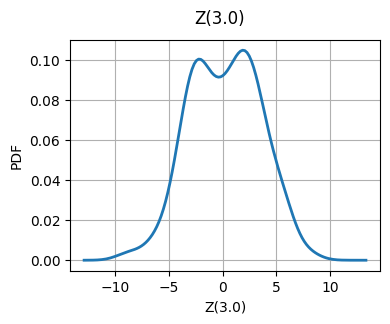

In [26]:
testSample = ot.Sample(nbTrajectories, 1)
for j in range(nbTrajectories):
    testSample[j] = sample[j][i]

graph = ot.KernelSmoothing().build(testSample).drawPDF()
graph.setTitle(f"Z({xi})")
graph.setXTitle(f"Z({xi})")
graph.setLegends([""])
_ = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

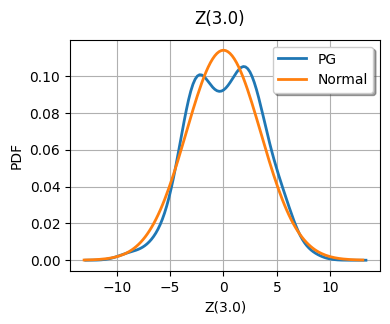

In [27]:
graph = ot.KernelSmoothing().build(testSample).drawPDF()
graph.setLegends(["PG"])
# Loi normale attendue
N = ot.Normal(0.0, amplitude[0])
curve = N.drawPDF()
curve.setLegends(["Normal"])
graph.add(curve)
graph.setTitle("")
graph.setTitle(f"Z({xi})")
graph.setXTitle(f"Z({xi})")
_ = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

On observe que, à la date $x=3$ (i.e. la 30-ème date), l'échantillon des valeurs suit une loi gaussienne.

Pour le confirmer, nous dessinons la droite de Henry, qui est le QQ-Plot appliqué à la loi normale.

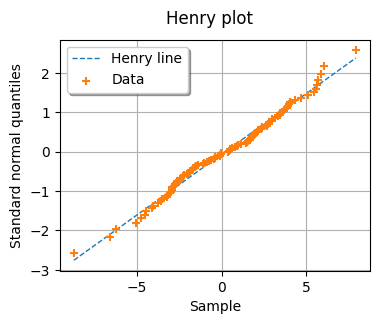

In [28]:
graph = ot.VisualTest.DrawHenryLine(testSample)
_ = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

Puisque les points sont proches de la droite, cela signifie que la distribution des points est gaussienne.